# Processamento Inicial

### Importa bibliotecas

In [351]:
import nltk
import pandas as pd
import os
import numpy as np
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import geopandas as gpd
from collections import Counter

### Define o diretório de trabalho

### Leitura da base de reclamações

In [340]:
data = pd.read_csv('base reclamações.csv',encoding='windows-1252',sep =';')
# verificação visual das 5 primeiras linhas
data.tail()

,Regiao,estado,empresa,subsidiaria,area,serviço,problema,faixa etarea
42302,Sudeste,SP,B2W COMPANHIA DIGITAL,AMERICANAS.COM/SUBMARINO/SHOPTIME/SOUBARATO,COMÉRCIO VAREJISTA DE OUTROS PRODUTOS NÃO ESPE...,Microcomputador / Produtos de Informática,Não entrega/demora na entrega do produto,Nao Informada
42303,Sudeste,SP,ADIDAS DO BRASIL LTDA,ADIDAS.COM.BR,COMÉRCIO ATACADISTA DE CALÇADOS,Vestuário ( Calçado / Roupa ),Não entrega/demora na entrega do produto,entre 31 a 40 anos
42304,Sudeste,SP,RN COMERCIO VAREJISTA S/A,RICARDOELETRO.COM.BR/INSINUANTE.COM/ELETROSHOP...,COMÉRCIO VAREJISTA ESPECIALIZADO DE ELETRODOMÉ...,"Acessório Para Vestuário ( Bolsa, Cinto, Chapé...",Produto entregue diferente do pedido,entre 21 a 30 anos
42305,Sudeste,SP,DECOLAR.COM LTDA,AGÊNCIA DECOLAR,AGÊNCIAS DE VIAGENS,Agências e Operadoras de viagens (pacotes turí...,Recusa injustificada em prestar serviço,Nao Informada
42306,Sudeste,SP,ESAB ESCOLA SUPERIOR ABERTA DO BRASIL LTDA,NaN,EDUCAÇÃO SUPERIOR - GRADUAÇÃO E PÓS-GRADUAÇÃO,"Escola ( Pré, 1º, 2º Graus e Superior )",Serviço não fornecido (entrega/instalação/não ...,entre 31 a 40 anos


### Quantidade de linhas e de colunas do dataframe lido

In [341]:
data.shape

(42307, 8)

## Colunas da tabela

In [342]:
data.columns

Index(['Regiao ', 'estado', 'empresa', 'subsidiaria  ', 'area ', 'serviço',
       'problema', 'faixa etarea'],
      dtype='object')

### Localização das colunas com valores "null"

In [343]:
data.isnull().sum()

Regiao              0
estado              0
empresa             1
subsidiaria      6530
area             5329
serviço             0
problema         8936
faixa etarea        0
dtype: int64

# Tratamento das empresas

### Filtrando as empresas com reclamação em um determinado estado e trazendo somente a coluna empresa[Exercício 1]/serviço[exercício 2]: 
### MG

In [344]:
df_empresa = data.loc[data['estado'] == 'MG','empresa'].to_frame()
df_servico = data.loc[data['estado'] == 'MG','serviço'].to_frame()
df_uf = data.groupby(['estado','empresa']).size().reset_index(name='total_reclamacoes')
df_problema = pd.DataFrame()
df_problema['problema'] = data['problema']

In [345]:
df_empresa.shape

(3460, 1)

In [346]:
df_servico.shape

(3460, 1)

In [347]:
df_problema.shape

(42307, 1)

### Verificação se há algum "null"

In [315]:
df_empresa.isnull().sum()

empresa    0
dtype: int64

In [316]:
df_servico.isnull().sum()

serviço    0
dtype: int64

In [317]:
df_uf.isnull().sum()

estado               0
empresa              0
total_reclamacoes    0
dtype: int64

In [348]:
df_problema.isnull().sum()

problema    8936
dtype: int64

### Remoção dos "nulls" encontrados

In [349]:
df_problema.dropna(inplace=True)
df_problema.isnull().sum()

problema    0
dtype: int64

### Substitui:

#### " " por "_" (espaço)

#### "/" por "" 

#### "," por "" 

#### "(" por "" 

#### ")" por "" 

#### "-" por ""

#### "." por ""

#### "\t" por "" (tab)

### para o wordcloud funcionar

In [319]:
dicionario = {" E ":' ',' ':'_','/':'',',':'','\\(':'','\\)':'',"-":'','\\.':'',r"^\t":''}

df_empresa["Nome Empresa Sem Espaço"] = df_empresa.replace({'empresa': dicionario},regex=True)

df_servico["Nome Empresa Sem Espaço"] = df_servico.replace({'serviço': dicionario},regex=True)

### Converte o nome das empresas para letras minúsculas

In [320]:
df_empresa["Nome Empresa Sem Espaço"] = df_empresa["Nome Empresa Sem Espaço"].str.lower()

df_servico["Nome Empresa Sem Espaço"] = df_servico["Nome Empresa Sem Espaço"].str.lower()

### Apreciação inicial do que foi obtido

In [321]:
print (df_empresa.groupby("Nome Empresa Sem Espaço").size().sort_values(ascending=False))

Nome Empresa Sem Espaço
telemar_norte_leste_sa                              242
oi_móvel_sa                                          87
caixa_economica_federal                              80
magazine_luiza_sa                                    56
samsung_eletronica_da_amazonia_ltda                  48
                                                   ... 
fiat_automóveis_sa                                    1
fidc_aymoré_financiamento_arrendamento_mercantil      1
fisiofenix_colchoaria_ltda__me                        1
fje_odontologia_ltda__me                              1
itau_unibanco_sa__banco_itaú                          1
Length: 1310, dtype: int64


In [322]:
print (df_servico.groupby("Nome Empresa Sem Espaço").size().sort_values(ascending=False))

Nome Empresa Sem Espaço
telefone__convencional_celular_interfone_etc_                                                               429
cartão_de_crédito                                                                                           237
telefonia_celular                                                                                           228
telefonia_fixa__plano_de_expansão__compra_e_venda__locação_                                                 214
banco_comercial                                                                                             200
                                                                                                           ... 
profissional_liberal__médico                                                                                  1
material_de_escritório__escola__arquivo_borracha_clipes_grampeador_sulfite_caderno_caneta_apontador_etc_      1
medicamento_alopático__manipulado__industrializado_                             

### Criação de uma string única com todas as ocorrências dos nomes das empresas

In [323]:
string_empresas = " ".join([text for text in df_empresa["Nome Empresa Sem Espaço"]])

string_servicos = " ".join([text for text in df_servico["Nome Empresa Sem Espaço"]])

### Geração do wordcloud das empresas mais reclamadas

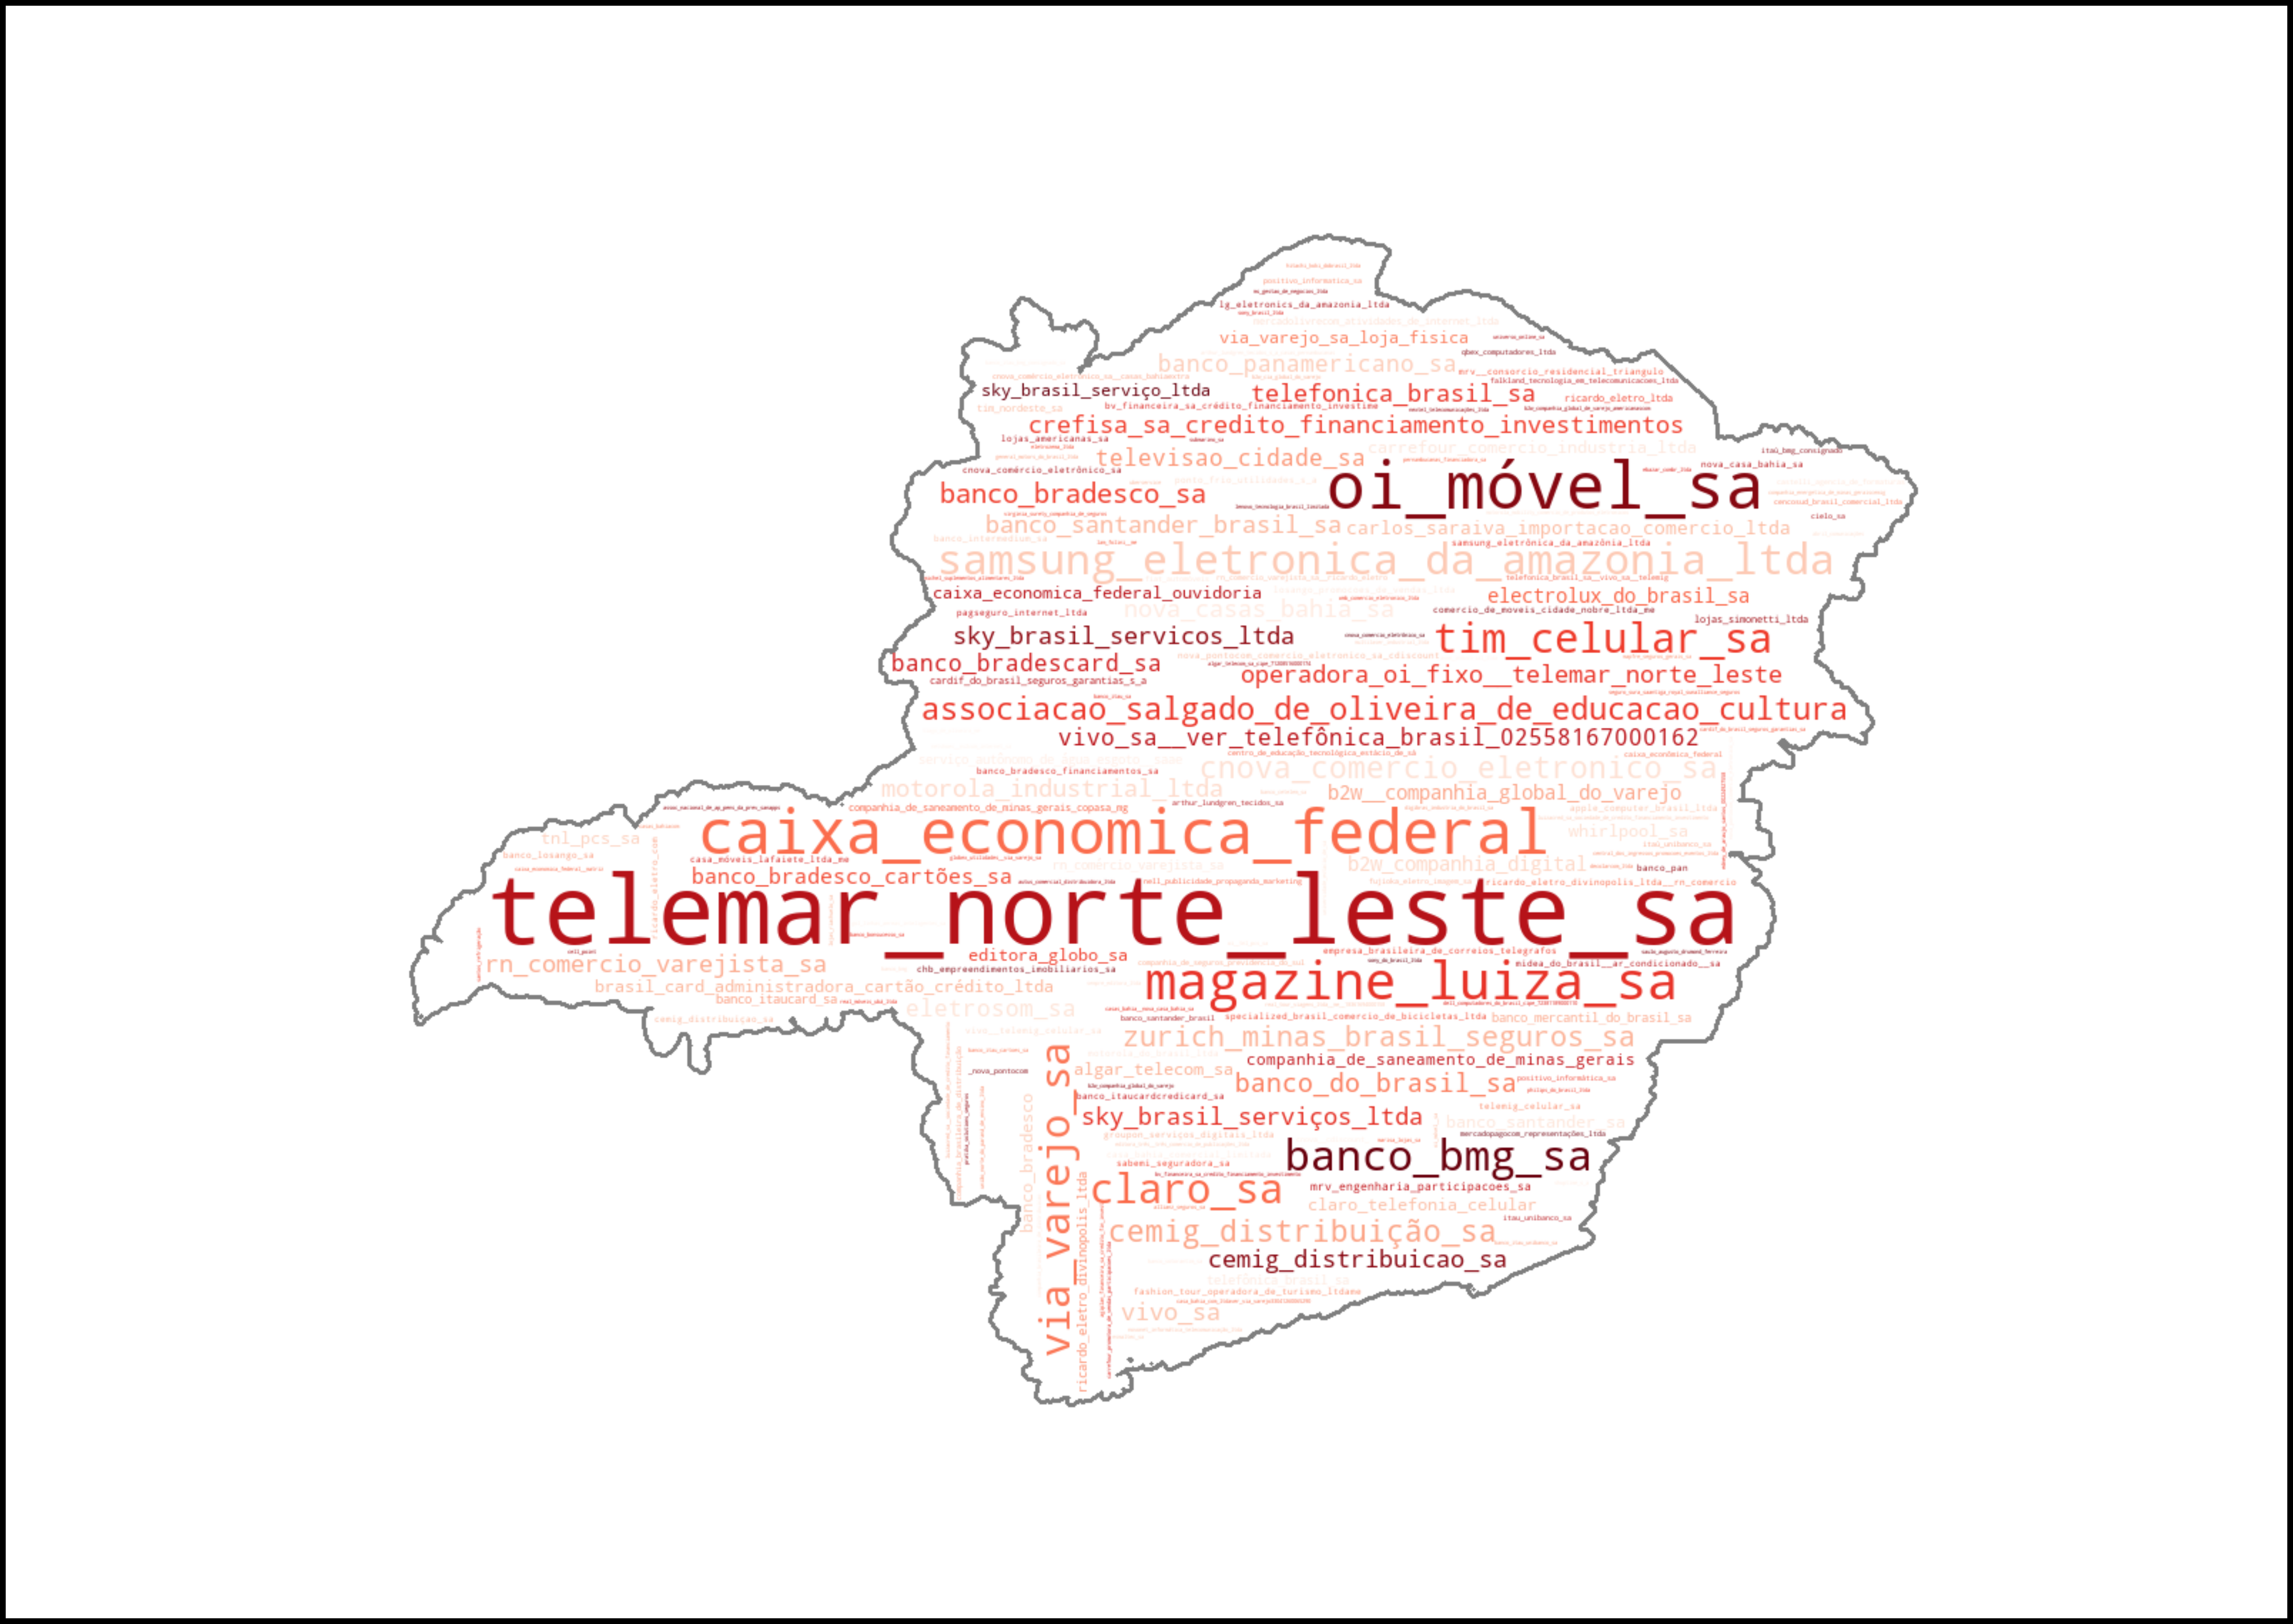

In [324]:
estado_mask = np.array(Image.open("minas_gerais2.png"))

wordcloud_empresas = WordCloud(background_color="white",collocations=False,
                              colormap="Reds_r",
                              width = 3000,
                              height = 2000,
                              max_font_size=1000,
                              #max_words=20, #total de empresas na cloud
                              mask=estado_mask, #inserindo o mapa do estado de máscara
                              contour_width=3, contour_color='gray' #definindo o contorno da imagem
                             ).generate(string_empresas)
plt.figure(figsize = (40,30),
           facecolor = 'k',
           edgecolor = 'k')
plt.imshow(wordcloud_empresas, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("Empresa_wordcloud.png")
plt.show()

### Geração do wordcloud dos 75 serviços mais reclamadas

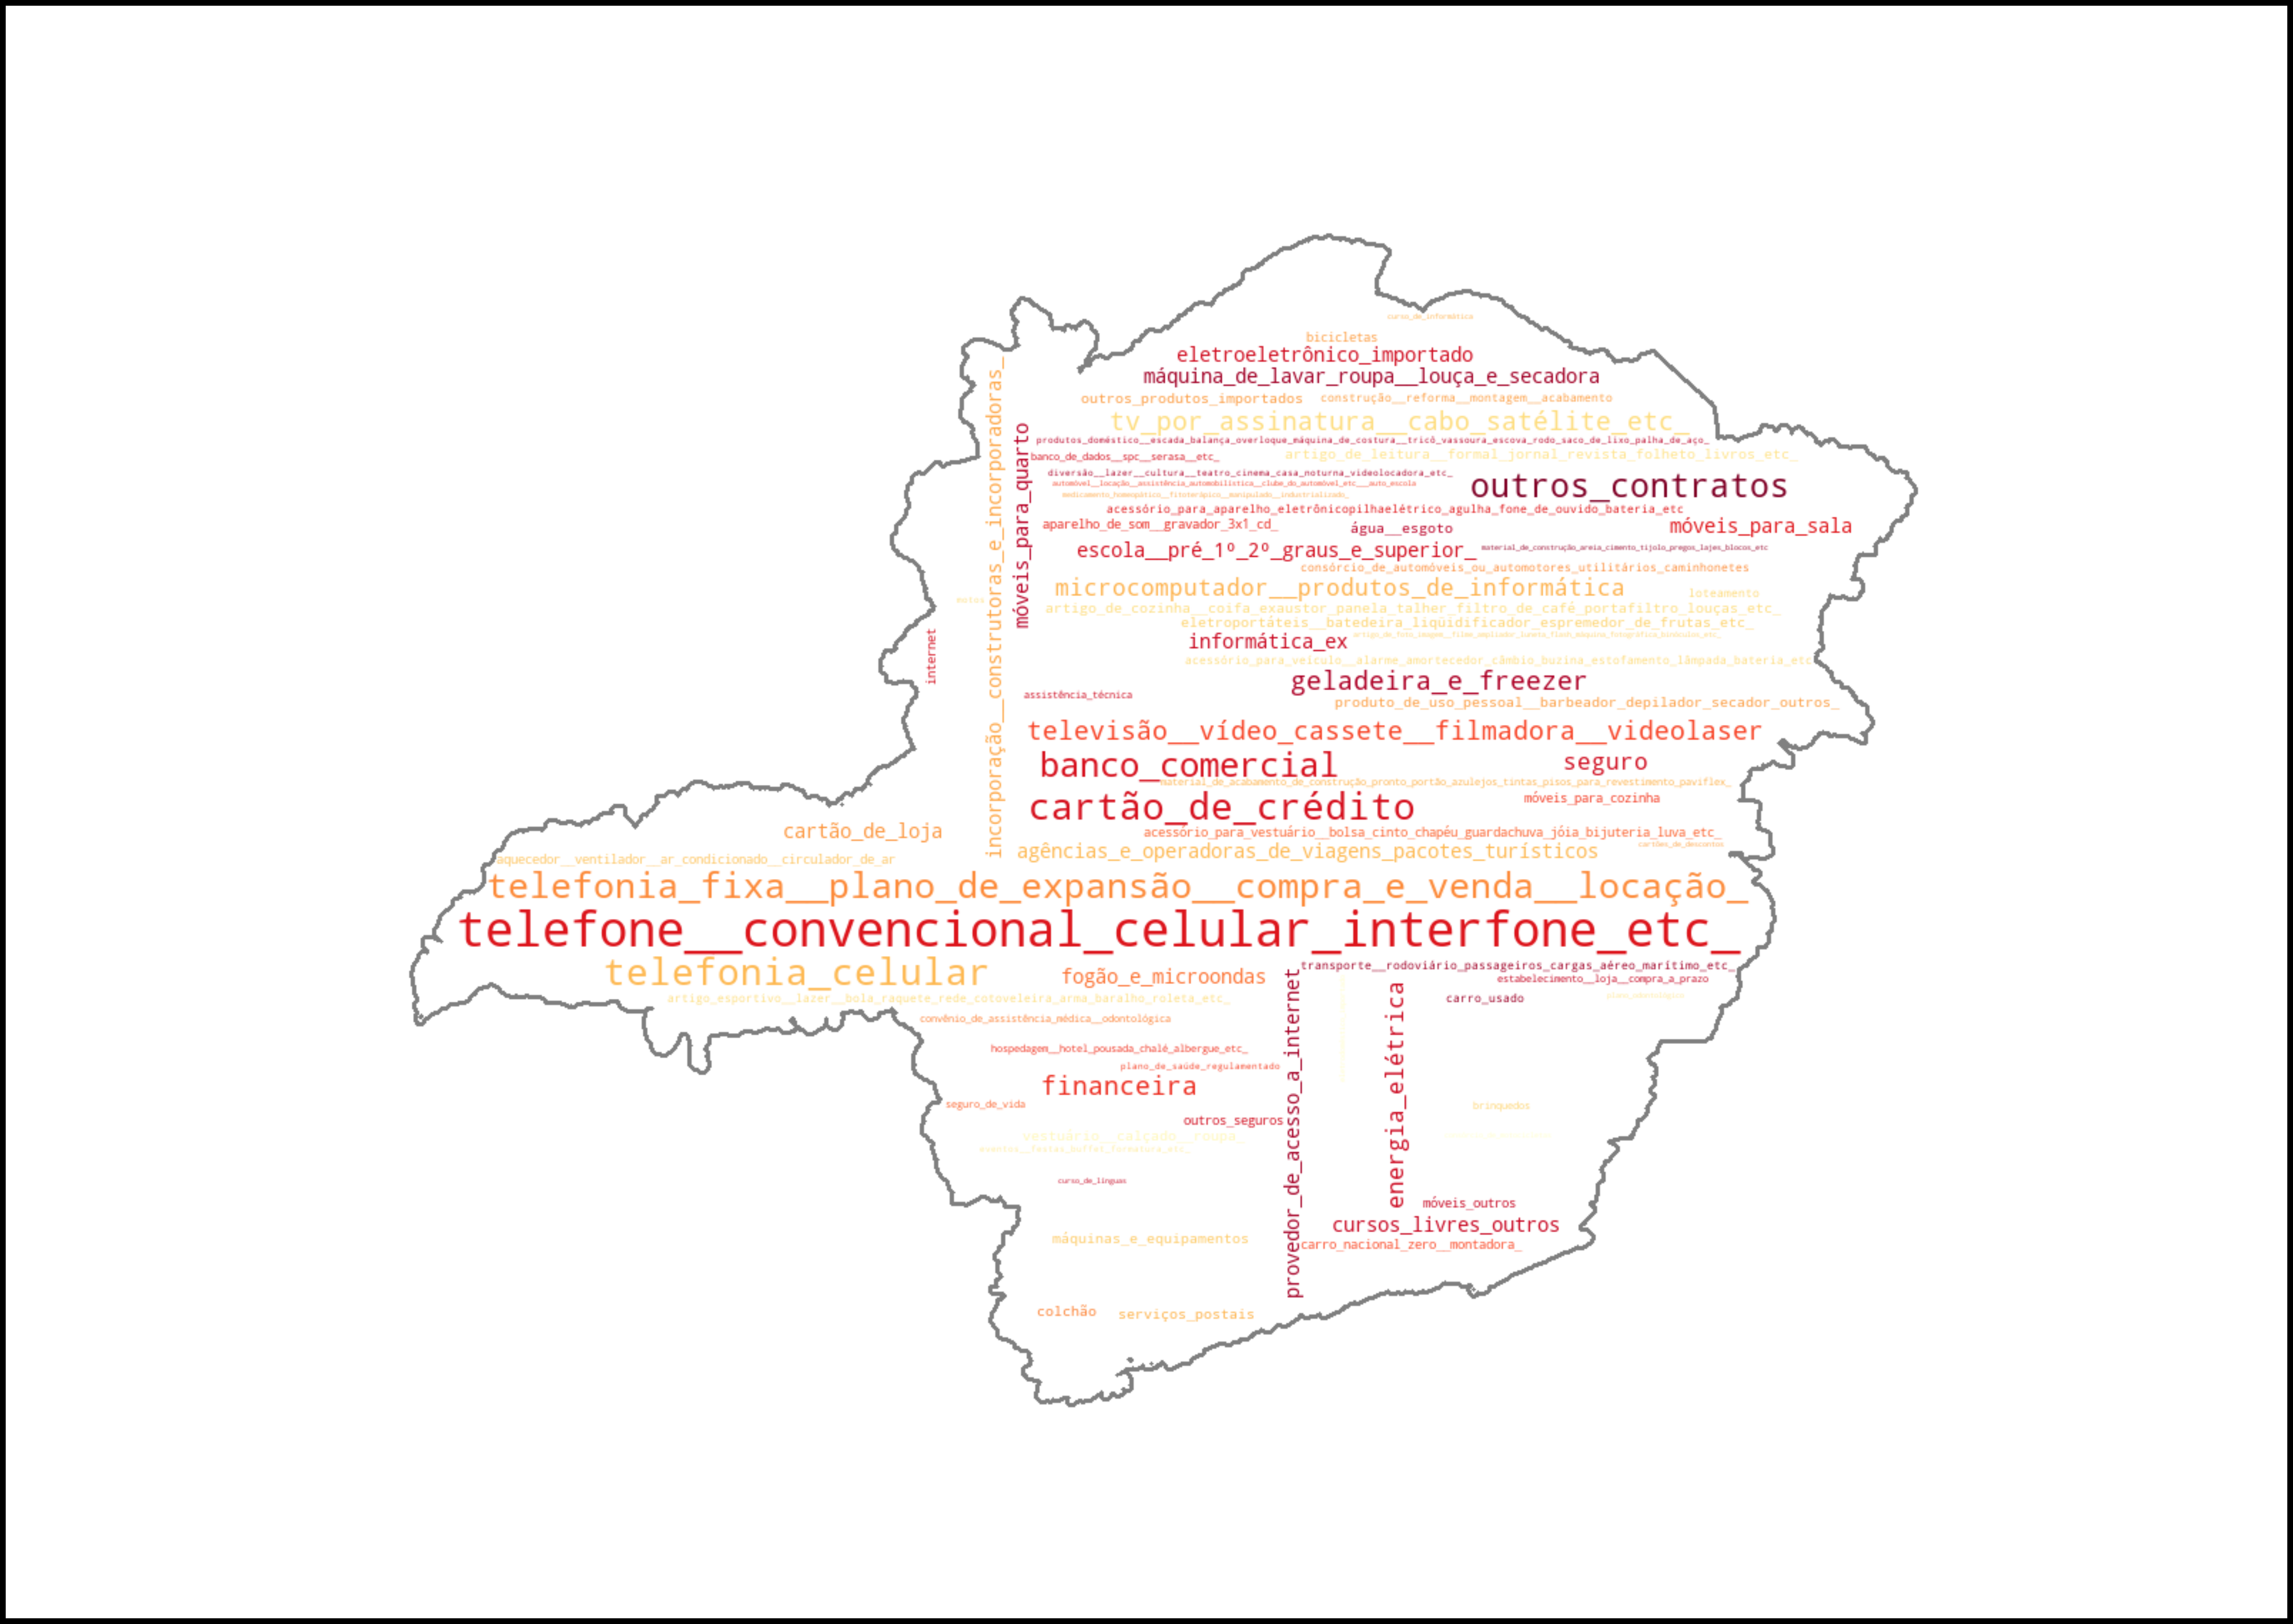

In [325]:
estado_mask = np.array(Image.open("minas_gerais2.png"))

wordcloud_servicos = WordCloud(background_color="white",collocations=False,
                              colormap="YlOrRd_r",
                              width = 3000,
                              height = 2000,
                              max_font_size=1000,
                              max_words=75, #total de empresas na cloud
                              mask=estado_mask, #inserindo o mapa do estado de máscara
                              contour_width=3, contour_color='gray' #definindo o contorno da imagem
                             ).generate(string_servicos)
plt.figure(figsize = (40,30),
           facecolor = 'k',
           edgecolor = 'k')
plt.imshow(wordcloud_servicos, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("Servico_wordcloud.png")
plt.show()

### Criando dataframe com a empresa com mais reclamações em cada estado

In [326]:

# Obtendo os índices das linhas com o maior total de reclamações para cada estado
idx = df_uf.groupby(['estado'])['total_reclamacoes'].idxmax()

# Selecionando essas linhas do DataFrame original
df_maior_reclamacao = df_uf.loc[idx]

print(df_maior_reclamacao)


      estado                                            empresa  \
166       CE                COMPANHIA DE AGUA E ESGOTO DO CEARA   
574       ES                                      BANCO BMG S.A   
2703      GO                NOVO MUNDO MOVEIS E UTILIDADES LTDA   
3498      MA                     AGUAS DE TIMON SANEAMENTO LTDA   
4829      MG                          TELEMAR NORTE E LESTE S/A   
5066      MS    ARTHUR LUNDGREN TECIDOS S A CASAS PERNAMBUCANAS   
6938      MT  ENERGISA MATO GROSSO-DISTRIBUIDORA DE ENERGIA S/A   
7778      PA                     CENTRAIS ELÉTRICAS DO PARÁ S/A   
8020      PB                                        TNL PCS S/A   
8038      PE                                          ELETROLUX   
8164      PI             COMPANHIA ENERGETICA DO PIAUÍ - CEPISA   
9366      RN                           MOTOROLA INDUSTRIAL LTDA   
10295     RO                              OI S.A CIP ELETRONICA   
10546     RS                           SKY BRASIL SERVICOS LTD

In [327]:
df_maior_reclamacao.shape

(17, 3)

In [328]:
df_maior_reclamacao.columns

Index(['estado', 'empresa', 'total_reclamacoes'], dtype='object')

In [329]:
#df_maior_reclamacao = df_maior_reclamacao.drop(columns=[df_maior_reclamacao.columns[0],df_maior_reclamacao.columns[3],df_maior_reclamacao.columns[4],df_maior_reclamacao.columns[5],df_maior_reclamacao.columns[6],df_maior_reclamacao.columns[7]])
#print(df_maior_reclamacao)

In [331]:
df_maior_reclamacao.head(20)

,estado,empresa,total_reclamacoes
166,CE,COMPANHIA DE AGUA E ESGOTO DO CEARA,119
574,ES,BANCO BMG S.A,18
2703,GO,NOVO MUNDO MOVEIS E UTILIDADES LTDA,136
3498,MA,AGUAS DE TIMON SANEAMENTO LTDA,14
4829,MG,TELEMAR NORTE E LESTE S/A,124
5066,MS,ARTHUR LUNDGREN TECIDOS S A CASAS PERNAMBUCANAS,102
6938,MT,ENERGISA MATO GROSSO-DISTRIBUIDORA DE ENERGIA S/A,142
7778,PA,CENTRAIS ELÉTRICAS DO PARÁ S/A,149
8020,PB,TNL PCS S/A,14
8038,PE,ELETROLUX,1


C:\Users\silve\AppData\Local\Temp\ipykernel_18636\2047268234.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(brasil.geometry.centroid.x, brasil.geometry.centroid.y, brasil['empresa']):


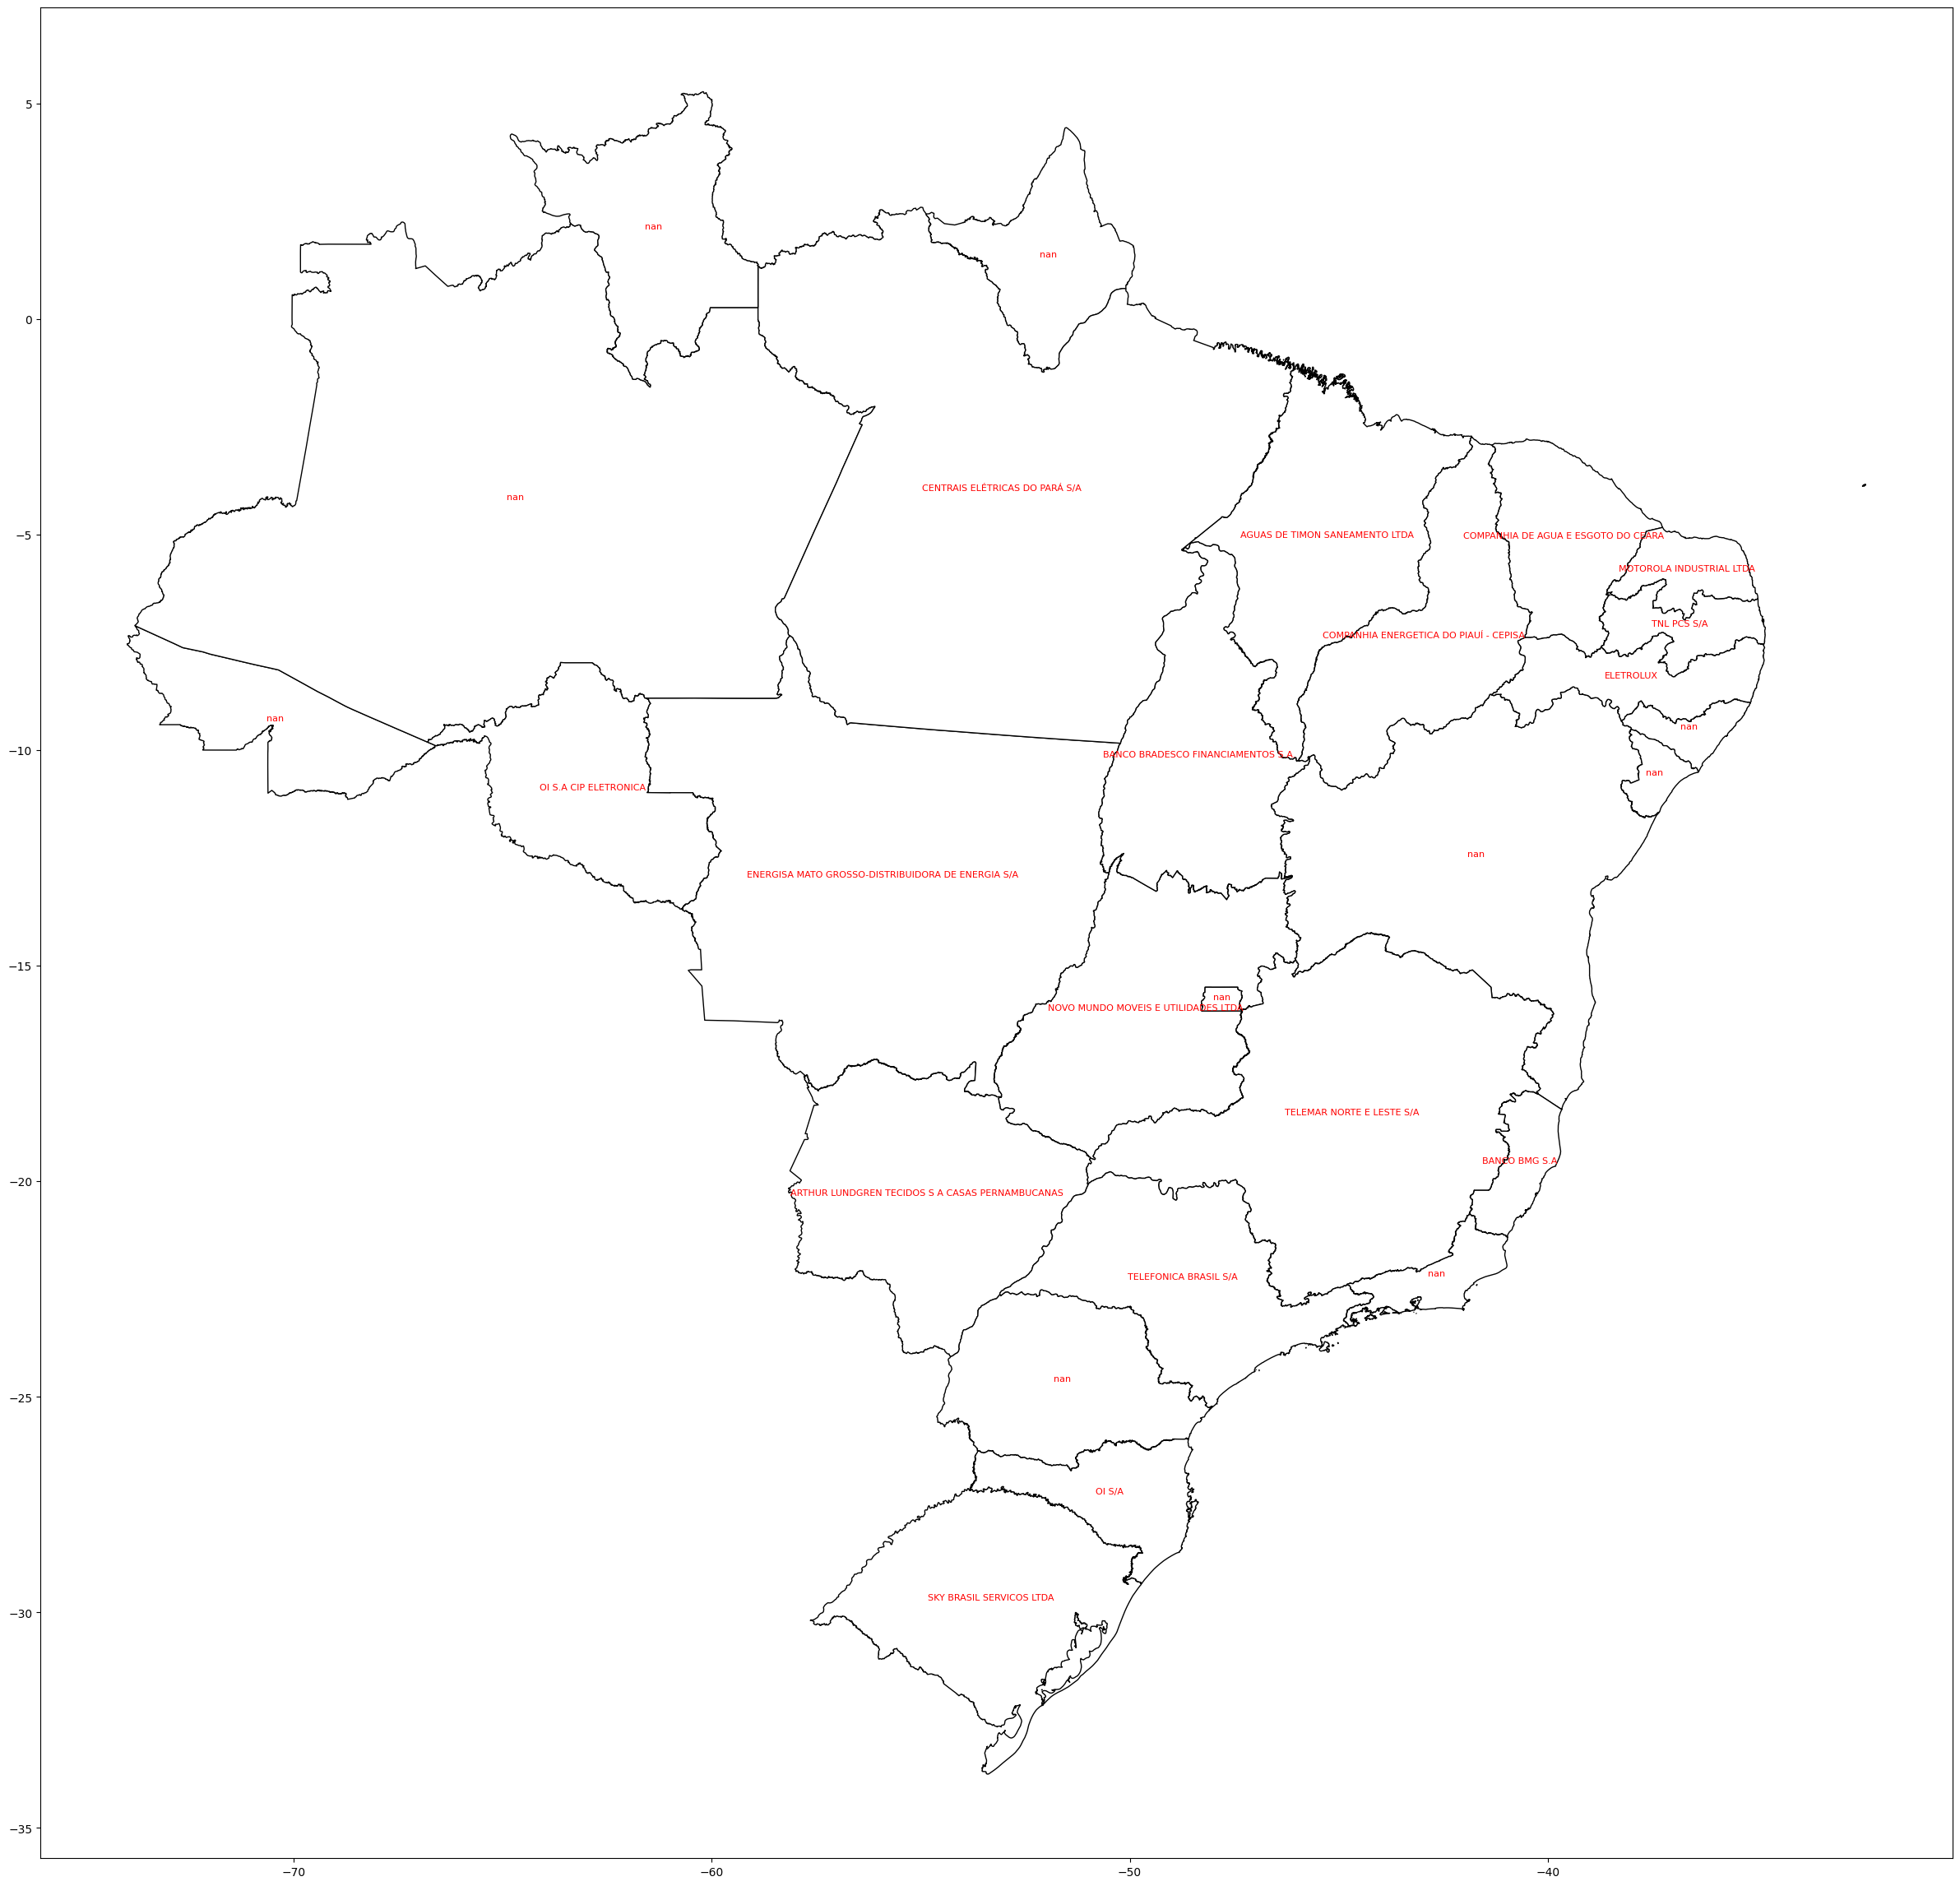

In [374]:
# Carregando o shapefile do Brasil (disponível em geojson)
brasil = gpd.read_file('https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson')

# Mesclando os dados do DataFrame com os dados geográficos
brasil = brasil.merge(df_maior_reclamacao, how='left', left_on='sigla', right_on='estado')

# Plotando o mapa
fig, ax = plt.subplots(figsize=(30, 30))
brasil.plot(ax=ax, color='white', edgecolor='black')

# Adicionando o nome das empresas no centro de cada estado
for x, y, label in zip(brasil.geometry.centroid.x, brasil.geometry.centroid.y, brasil['empresa']):
    plt.text(x, y, label, fontsize=8, ha='center',color='red')

plt.show()


### Para ficar mais claro, é interessante um diagrama de barras ordenado pela quantidade decrescente de problemas, limitado aos 45 mais reclamados. 

In [350]:
df_problema.tail()

,problema
42302,Não entrega/demora na entrega do produto
42303,Não entrega/demora na entrega do produto
42304,Produto entregue diferente do pedido
42305,Recusa injustificada em prestar serviço
42306,Serviço não fornecido (entrega/instalação/não ...


### Criando uma lista com todos os problemas

In [354]:
# Isso cria uma lista enorme combinando todos os valores de tokens
lista_problemas = df_problema.values.flatten().tolist()

lista_problemas[:10]

['Contrato (não cumprimento, alteração, transferencia, irregularidade, rescisão, etc.)',
 'Contrato - Rescisão/alteração unilateral',
 'PID - Pedido de Indenização por Danos Morais',
 'Vicio de qualidade (mal executado, inadequado, impróprio)',
 'Vicio de qualidade (mal executado, inadequado, impróprio)',
 'Desistência do serviço (artigo 49 - descumprimento)',
 'Não entrega/demora na entrega do produto',
 'Serviço não fornecido (entrega/instalação/não cumprimento da oferta/contrato)',
 'Cobrança indevida/abusiva',
 'Vicio de qualidade (mal executado, inadequado, impróprio)']

In [360]:
# Converte a lista em um dicionário com contagem de valores
conta_problemas = Counter(lista_problemas)

# Inverter a chave / valores no dicionário para classificarReverter a chave / valores no dicionário para classificar
conta_problemas = list(zip(conta_problemas.values(), conta_problemas.keys()))

# Classifique a lista por contagem
conta_problemas = sorted(conta_problemas, reverse=True)

# Imprime as 10 palavras mais comuns
conta_problemas[:10]

[(6043, 'Produto com vício'),
 (4695, 'Cobrança indevida/abusiva'),
 (3272, 'Cobrança indevida.'),
 (1726, 'Peso, volume e quantidade'),
 (1438, 'Garantia (Abrangência, cobertura, etc.)'),
 (1090,
  'Contrato (não cumprimento, alteração, transferencia, irregularidade, rescisão, etc.)'),
 (1063, 'Contrato - Rescisão/alteração unilateral'),
 (1020, 'Não entrega/demora na entrega do produto'),
 (920,
  'Serviço não fornecido (entrega/instalação/não cumprimento da oferta/contrato)'),
 (822, 'Vicio de qualidade (mal executado, inadequado, impróprio)')]

In [364]:
# Selecionando os 45 primeiros itens da lista
conta_45_problemas = conta_problemas[:45]

problemas = [item[1] for item in conta_45_problemas]
quantidades = [item[0] for item in conta_45_problemas]

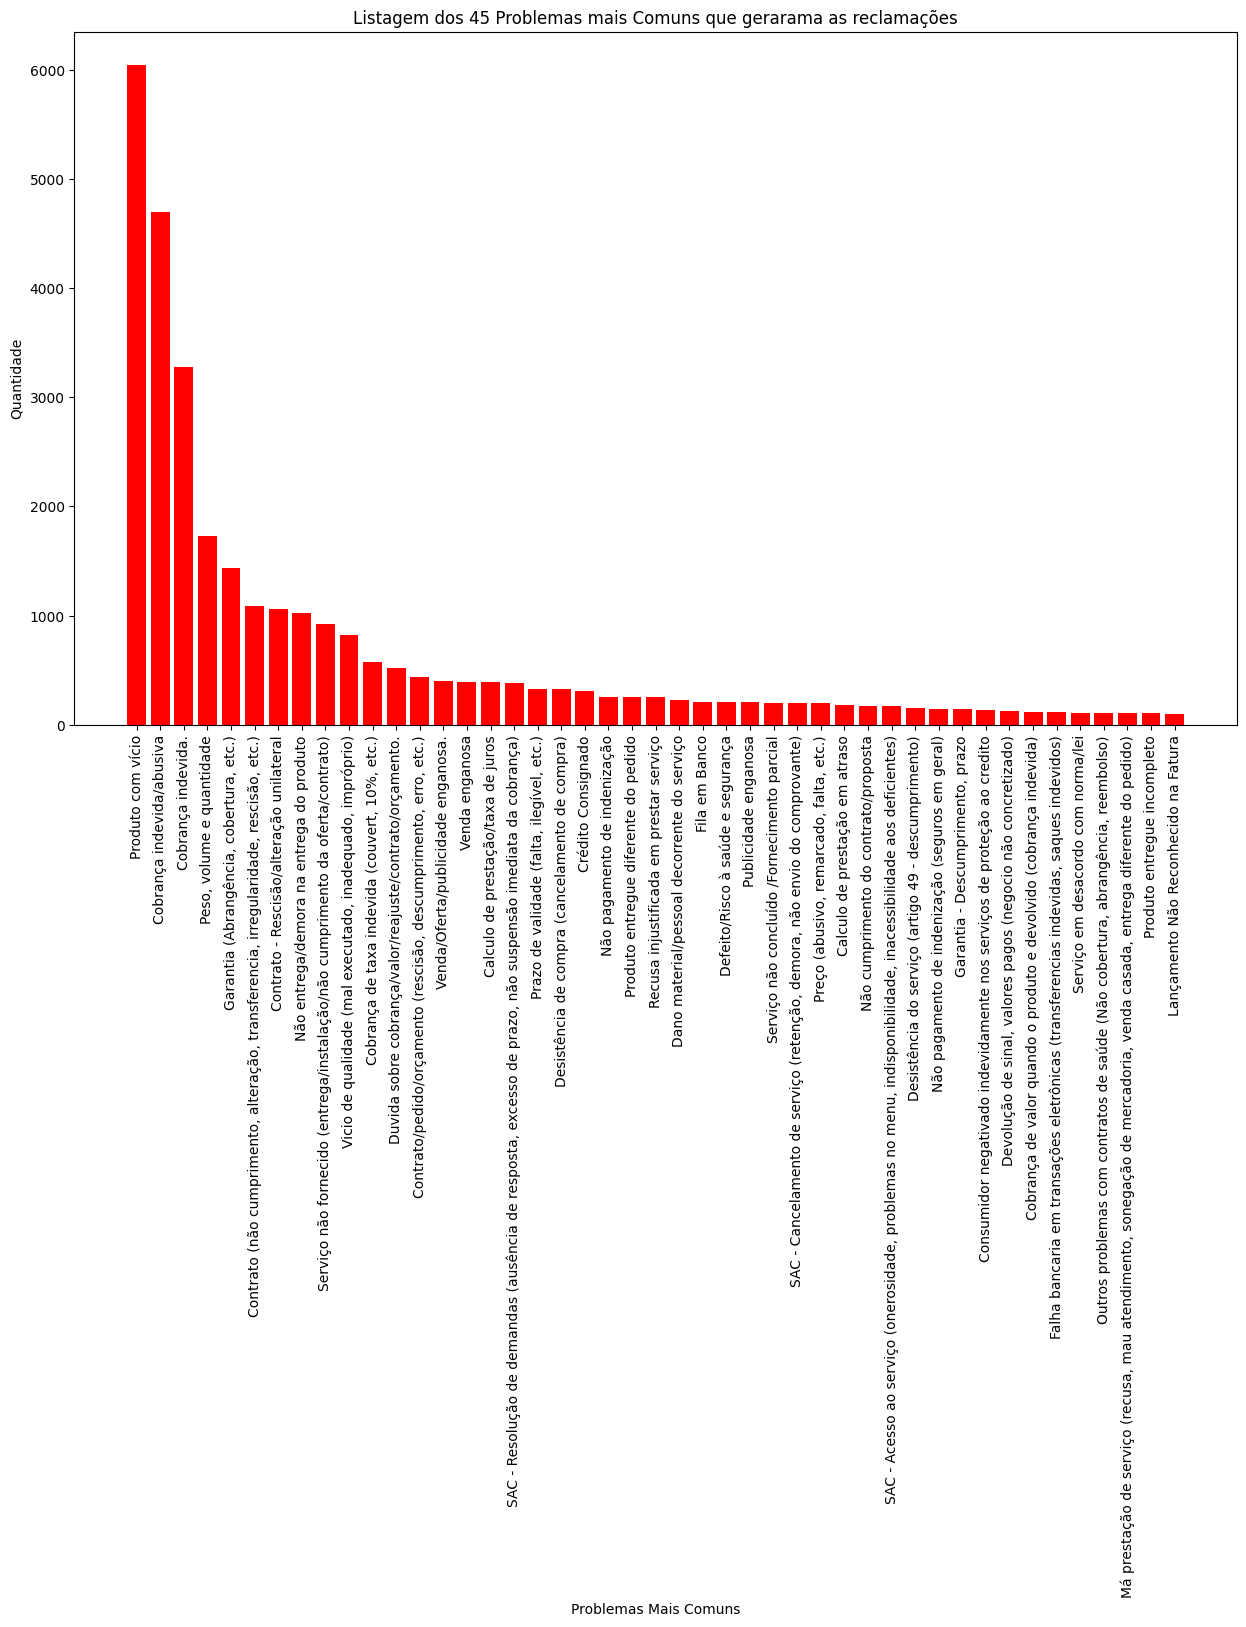

In [397]:
# Criando um gráfico de barras
plt.figure(figsize=(15, 9))
plt.bar(problemas, quantidades, color='red')

plt.xlabel('Problemas Mais Comuns')
plt.xticks(rotation=90, fontsize=10, ha='center')
plt.ylabel('Quantidade')
plt.title('Listagem dos 45 Problemas mais Comuns que gerarama as reclamações')

plt.show()